<a href="https://colab.research.google.com/github/shamim-hussain/cnn_vae_gan_rl/blob/main/celeba_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CelebA VAE

## Prepare downsampled, cropped, grayscale data

In [62]:
import zipfile
from tqdm import tqdm
import numpy as np
import gzip

# The dataset 'img_align_celeba.zip' is downloaded from
# https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ
with zipfile.ZipFile('img_align_celeba.zip', 'r') as file:
    image_files = [f.filename for f in file.filelist if (not f.is_dir()) and f.filename.endswith('.jpg')]
    X_train = np.empty([len(image_files),45,45,1],dtype='uint8')
    for i, filename in enumerate(tqdm(image_files)):
        X_train[i] = tf.io.decode_and_crop_jpeg(file.read(filename),
                                                crop_window=[5,0,45,45],
                                                ratio=4,
                                                channels=1).numpy()
X_train = X_train.squeeze()
with gzip.GzipFile('celeba_gray_45x45.npy.gz','wb',5) as save_file:
    np.save(save_file, X_train)

100%|████████████████████████████████████████████████████████████████████████| 202599/202599 [00:43<00:00, 4633.38it/s]


## Load previously prepared data

In [1]:
import numpy as np
import gzip

with gzip.GzipFile('celeba_gray_45x45.npy.gz','rb') as save_file:
    X_train = np.load(save_file)
X_train = X_train.astype('float32')/255.

### View collage of images

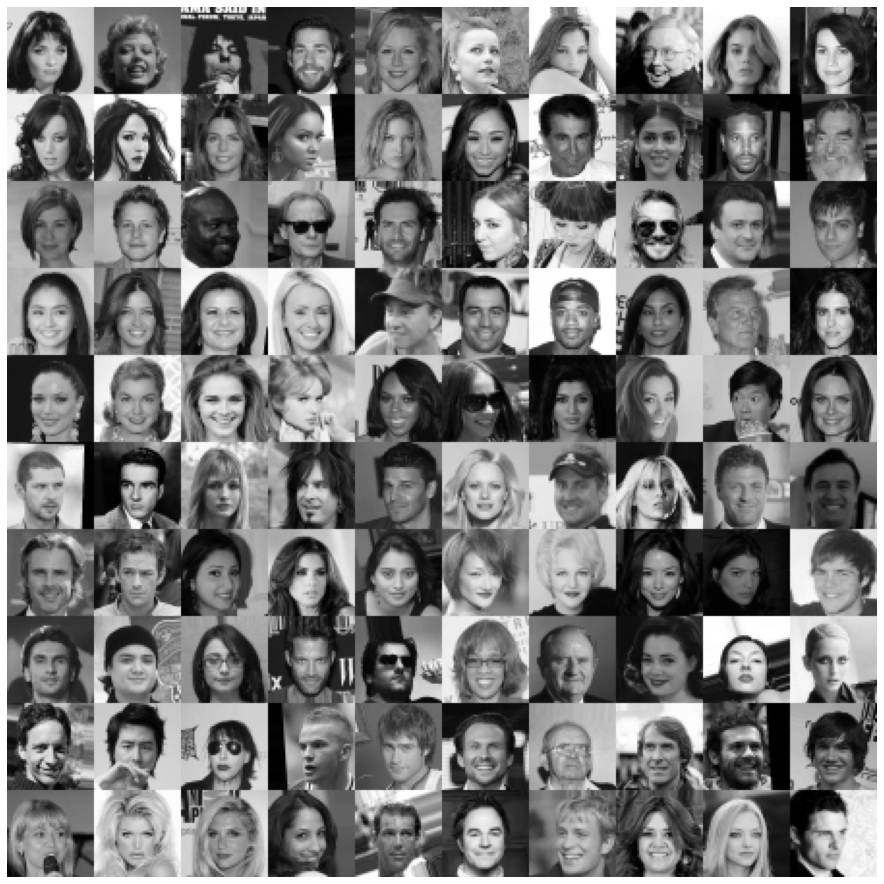

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
plt.imshow(X_train[600:700].transpose(1,2,0).reshape(45,45,10,10).transpose(2,0,3,1).reshape(450,450),cmap='gray')
plt.axis('off')
plt.show()

# NMF

In [2]:
import numba as nb

@nb.njit
def overlapped_segments(X):
    segments = np.zeros((X.shape[0],22,22,3,3),dtype=np.float32)

    for k, x in enumerate(X):
        for i1,i2 in zip(range(22),range(0,43,2)):
            for j1,j2 in zip(range(22),range(0,43,2)):
                segments[k,i1,j1] = x[i2:i2+3,j2:j2+3]
    return segments

@nb.njit
def overlap_and_add(segments):
    X = np.zeros((segments.shape[0],45,45),dtype=np.float32)

    for k, seg in enumerate(segments):
        for i1,i2 in zip(range(22),range(0,43,2)):
            for j1,j2 in zip(range(22),range(0,43,2)):
                X[k,i2:i2+3,j2:j2+3] += seg[i1,j1]
    return X


In [3]:
X_train_segments = overlapped_segments(X_train)
X_train_segments = X_train_segments.reshape(-1,3*3)
X_train_segments.shape

(98057916, 9)

In [4]:
seg_inds = np.arange(len(X_train_segments),dtype=int)
np.random.shuffle(seg_inds)
segment_samples = X_train_segments[seg_inds[:1000000]]

In [6]:
from sklearn.decomposition import NMF
nmf_components=4

nmf = NMF(n_components=nmf_components,verbose=2,max_iter=5000,tol=1e-5)
nmf.fit(segment_samples)

violation: 1.0
violation: 0.7665091780111726
violation: 0.695670775376261
violation: 0.5460716974747649
violation: 0.42808283104333333
violation: 0.35775356601226166
violation: 0.3054462057327671
violation: 0.26444023872779043
violation: 0.23128107714526933
violation: 0.202748861492808
violation: 0.17817987314499778
violation: 0.15674638885526332
violation: 0.1385220375598055
violation: 0.12271012696820169
violation: 0.11034975747498545
violation: 0.09940954252587914
violation: 0.08961810399322236
violation: 0.0809681914746443
violation: 0.07342490098362167
violation: 0.06703661537190343
violation: 0.061603497377019076
violation: 0.056703657817698774
violation: 0.05242817983300395
violation: 0.048807069507603565
violation: 0.0456388015162472
violation: 0.042958445197113164
violation: 0.040699534007761856
violation: 0.038795002823980775
violation: 0.0372773461425371
violation: 0.036060058723888164
violation: 0.03510945448837478
violation: 0.03446000963141521
violation: 0.033875447466450

NMF(max_iter=5000, n_components=4, tol=1e-05, verbose=2)

In [7]:
X_train_nmf = nmf.transform(X_train_segments)

violation: 1.0
violation: 0.25
violation: 0.03125
violation: 0.00390625
violation: 0.0008074025972746313
violation: 0.00012207034160383046
violation: 1.52587890625e-05
violation: 1.9073486328125e-06
Converged at iteration 9


In [8]:
print(X_train_segments[33])
print(nmf.inverse_transform(X_train_nmf[33]))

[0.83137256 0.49411765 0.28627452 0.3882353  0.29803923 0.23921569
 0.22352941 0.21960784 0.14117648]
[0.75014365 0.52347237 0.2710364  0.48683685 0.34546265 0.2142899
 0.19151416 0.16214523 0.17586774]


In [9]:
X_train_nmf = X_train_nmf.reshape(-1,22,22,nmf_components)

In [10]:
mask = overlap_and_add(np.ones_like(X_train[0:1]))
rconstructed = overlap_and_add(nmf.inverse_transform(X_train_nmf[33:34].reshape(-1,nmf_components)).reshape(-1,22,22,3,3))/mask

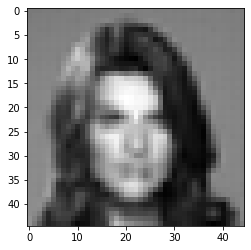

In [12]:
import matplotlib.pyplot as plt

plt.imshow(rconstructed.squeeze(),cmap='gray')

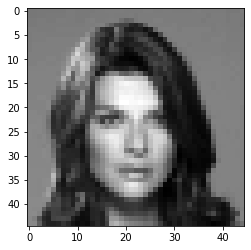

In [13]:
plt.imshow(X_train[33],cmap='gray')

#KMeans

In [2]:
import numba as nb

@nb.njit
def overlapped_segments(X):
    segments = np.zeros((X.shape[0],22,22,3,3),dtype=np.float32)

    for k, x in enumerate(X):
        for i1,i2 in zip(range(22),range(0,43,2)):
            for j1,j2 in zip(range(22),range(0,43,2)):
                segments[k,i1,j1] = x[i2:i2+3,j2:j2+3]
    return segments

@nb.njit
def overlap_and_add(segments):
    X = np.zeros((segments.shape[0],45,45),dtype=np.float32)

    for k, seg in enumerate(segments):
        for i1,i2 in zip(range(22),range(0,43,2)):
            for j1,j2 in zip(range(22),range(0,43,2)):
                X[k,i2:i2+3,j2:j2+3] += seg[i1,j1]
    return X

In [3]:
X_train_segments = overlapped_segments(X_train)
X_train_segments = X_train_segments.reshape(-1,3*3)
X_train_segments.shape

(98057916, 9)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
num_clusters = 2048

k_means = MiniBatchKMeans(n_clusters=num_clusters,
                          n_init=12,
                          batch_size=6*512,
                          max_iter=1,
                          max_no_improvement=15,
                          verbose=2,
                          compute_labels=False)

seg_inds = np.arange(len(X_train_segments),dtype=int)
np.random.shuffle(seg_inds)
segment_samples = X_train_segments[seg_inds]

k_means.fit(segment_samples)
# X_train_vq = k_means.labels_.reshape(-1,22,22)
X_train_vq = k_means.predict(X_train_segments).reshape(-1,22,22)
X_train_vq.shape

In [9]:
X_train_vq = k_means.predict(X_train_segments).reshape(-1,22,22)

Computing label assignment and total inertia


In [5]:
recons_mask = overlap_and_add(np.ones_like(X_train[0:1]))
centroids = k_means.cluster_centers_.reshape(-1,3,3)

def reconstruct_images(X):
    return overlap_and_add(centroids[X])/recons_mask

In [10]:
mask = overlap_and_add(np.ones_like(X_train[0:1]))
rconstructed = overlap_and_add(k_means.cluster_centers_[X_train_vq[99:100].reshape(-1)].reshape(-1,22,22,3,3))/mask

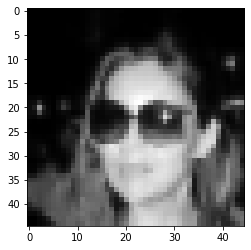

In [19]:
import matplotlib.pyplot as plt

plt.imshow(reconstruct_images(X_train_vq[2133:2134]).squeeze(),cmap='gray')

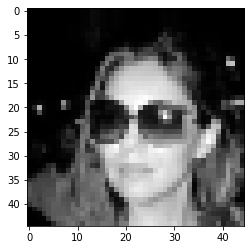

In [20]:
plt.imshow(X_train[2133],cmap='gray')

In [16]:
import zipfile
import pickle

with zipfile.ZipFile('images_vq_22x22x1024.zip',mode='w',
                     compression=zipfile.ZIP_DEFLATED,
                     compresslevel=5) as zfile:
    with zfile.open('images.npy','w') as file:
        np.save(file, X_train_vq.astype('int32'))
    with zfile.open('centroids.npy','w') as file:
        np.save(file, centroids.astype('float32'))
    with zfile.open('k_means.pkl','w') as file:
        data=pickle.dumps(k_means)
        file.write(data)

# VAE

In [25]:
X_train_vq.min()

0